# how to determine which parameters mostly affect a result? *A heart disease study*

In [1]:
# imports
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_curve, auc
from lime import lime_tabular
import shap
import eli5
import warnings
warnings.filterwarnings('ignore')
seed = 0
%matplotlib inline

## 1. Introduction
Heart disease is broad term used for diseases affecting the heart and circulatory system.
Heart disease is a major cause of disability and death all around the world.
Since heart is amongst the most vital organs of the body, its diseases affect the body altogether.

**Objective of this study**
1. Explore the kaggle's heart disease dataset using statistical inference and data analysis.
2. Explore different lassification algorithms for prediction using machine learning. 
3. Compare between the statistical inference results and the machine learning algorithms. 
4. hypothesize whether machine learning models learn statistically correlated features?


## 2. Data analysis
In this part, we will explore the data using statistical analysis and discover how different features of the data influence each other. 

In [2]:
# dataset loading
df = pd.read_csv('../proposal/heart.csv')

In [3]:
# get a summary of the data
print(df.describe().T)

           count        mean        std    min    25%    50%    75%    max
age       1025.0   54.434146   9.072290   29.0   48.0   56.0   61.0   77.0
sex       1025.0    0.695610   0.460373    0.0    0.0    1.0    1.0    1.0
cp        1025.0    0.942439   1.029641    0.0    0.0    1.0    2.0    3.0
trestbps  1025.0  131.611707  17.516718   94.0  120.0  130.0  140.0  200.0
chol      1025.0  246.000000  51.592510  126.0  211.0  240.0  275.0  564.0
fbs       1025.0    0.149268   0.356527    0.0    0.0    0.0    0.0    1.0
restecg   1025.0    0.529756   0.527878    0.0    0.0    1.0    1.0    2.0
thalach   1025.0  149.114146  23.005724   71.0  132.0  152.0  166.0  202.0
exang     1025.0    0.336585   0.472772    0.0    0.0    0.0    1.0    1.0
oldpeak   1025.0    1.071512   1.175053    0.0    0.0    0.8    1.8    6.2
slope     1025.0    1.385366   0.617755    0.0    1.0    1.0    2.0    2.0
ca        1025.0    0.754146   1.030798    0.0    0.0    0.0    1.0    4.0
thal      1025.0    2.323

### Dictionary: 
1. age: the age of a person (counted in years)
2. sex: biological sex of the person
    * 1 = male
    * 0 = female
3. cp: chest pain type
    * 0: typical angina
    * 1: atypical angina
    * 2: non-anginal pain
    * 3: asymptomatic
4. trestbps: resting blood pressure (mmHg - determined on admission to the hospital)
5. chol: serum cholestoral (mg/dl)
6. fbs: fasting blood sugar (is fbs greater than 120 mg/dl?)
    * 1 = true; 
    * 0 = false
7. restecg: resting electrocardiographic results
    * 0: normal
    * 1: ST-T wave abnormality
    * 2: Likely left ventricular hypertrophy
8. thalach: maximum heart rate achieved (beats per minute)
9. exang: exercise induced angina (binary parameter)
    * 1 = yes
    * 0 = no
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    * 0: up-sloping
    * 1: flat
    * 2: down-sloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 
    * 0 = error
    * 1 = fixed defect
    * 2 = normal 
    * 3 = reversable defect 
14. target (Lable): 
    * 0 = Healthy 
    * 1 = Sick

***Note on the target label:*** <br/>
Diagnosis of heart disease is based on angiographic disease status with the following parameter: 

Healthy: < 50% diameter narrowing <br/>
Sick:    > 50% diameter narrowing

### Preprocessing: 

In [4]:
### Null values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### There are no null values 

In [5]:
# Feature renaming for clarity
df = df.rename(columns = {'cp':'chest_pain_type', 'trestbps':'resting_blood_pressure', 'chol': 'cholesterol','fbs': 'fasting_blood_sugar', 
                'restecg' : 'rest_electrocardiographic', 'thalach': 'max_heart_rate_achieved', 'exang': 'exercise_induced_angina',
                'oldpeak': 'st_depression', 'slope': 'st_slope', 'ca':'num_major_vessels', 'thal': 'thalassemia'}, errors="raise")

df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 0] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 1] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 0] = 'normal'
df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 1] = 'ST-T wave abnormality'
df['rest_electrocardiographic'][df['rest_electrocardiographic'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 0] = 'upsloping'
df['st_slope'][df['st_slope'] == 1] = 'flat'
df['st_slope'][df['st_slope'] == 2] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 2] = 'normal'
df['thalassemia'][df['thalassemia'] == 3] = 'reversable defect'

print(df.dtypes)

age                            int64
sex                           object
chest_pain_type               object
resting_blood_pressure         int64
cholesterol                    int64
fasting_blood_sugar           object
rest_electrocardiographic     object
max_heart_rate_achieved        int64
exercise_induced_angina       object
st_depression                float64
st_slope                      object
num_major_vessels              int64
thalassemia                   object
target                         int64
dtype: object


In [6]:
# drop error data
df = df[df['thalassemia'] != 0]

In [7]:
# group numerial features together
numerical_features = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
# group binary features together
binary_features = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']
# group categorical features together
categorical_features = ['chest_pain_type', 'rest_electrocardiographic', 'st_slope', 'thalassemia'] + binary_features
all_features = numerical_features + categorical_features

### Analysis

Text(0.5, 1.05, 'Target variable distribution')

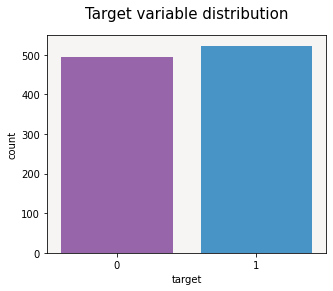

In [8]:
# distribution of sick vs healthy personal in the dataset.
colors = ["#9b59b6", "#3498db"]
plt.figure(figsize=(5, 4))
total = float(len(df))
ax = sns.countplot(df['target'], palette=colors)
ax.set_facecolor('#F6F5F4')
ax.set_title('Target variable distribution', fontsize=15, y=1.05)

In [9]:
print(df.target.value_counts())

1    523
0    495
Name: target, dtype: int64


#### We can see that the dataset is quite balanced with:
- 526 sick personal 
- 499 healthy personal

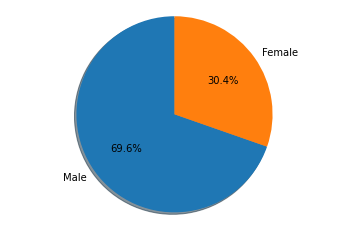

In [10]:
# distribution of gender in the dataset.
labels = 'Male', 'Female'
explode = (0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(df.sex.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### We can see that the dataset consists of:
- 69.6% male  
- 30.4% female

### Assesing numerical features affect on target label: 
- age 
- cholesterol
- resting blood pressure
- max heart rate achieved 
- ST depression
- num major vessels

Text(0.5, 0.98, 'Numerical features affect on target')

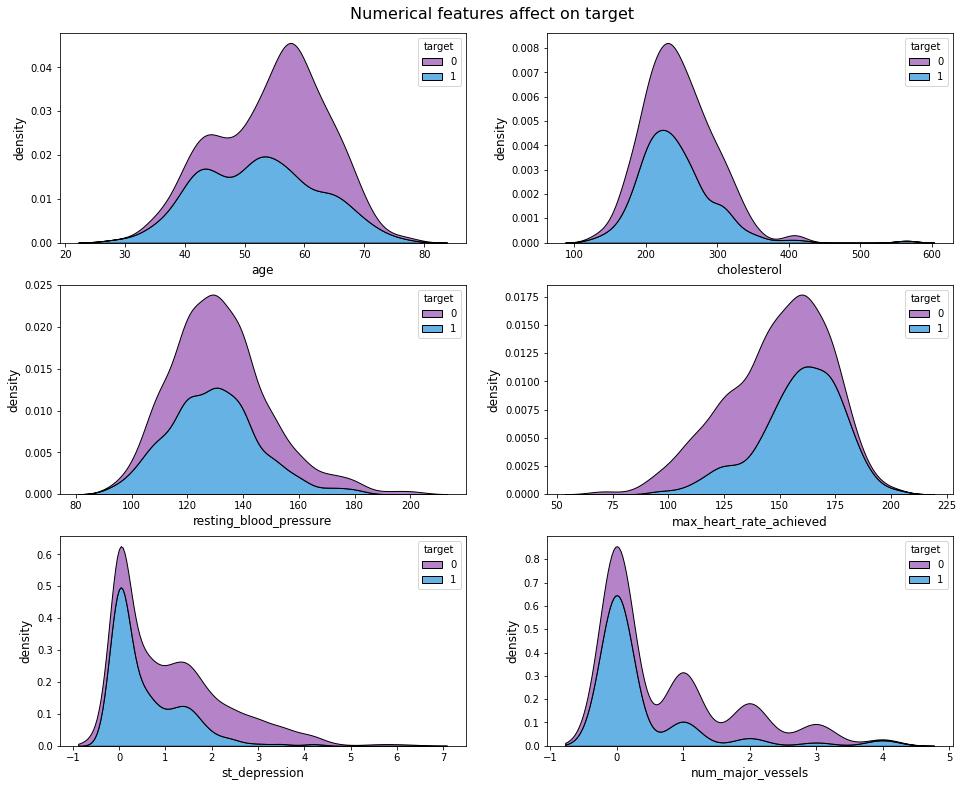

In [11]:
colors = ["#9b59b6", "#3498db"]
fig, ax = plt.subplots(3, 2, figsize=(16, 12))   
fig.subplots_adjust(top=0.95)
for idx, feature in enumerate(numerical_features):
    plt.subplot(3, 2, idx + 1)
    ax = sns.kdeplot(data=df, x=feature, hue="target", multiple="stack", palette=colors) 
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("density", fontsize=12)
plt.suptitle('Numerical features affect on target' ,fontsize = 16)

### Assesing categorical features affect on target label: 
- chest pain type
- rest electrocardiographic
- ST slope
- thalaseemia 
- sex
- fasting blood sugar
- exercise included angina

Text(0.5, 0.98, 'Categorical features affect on target')

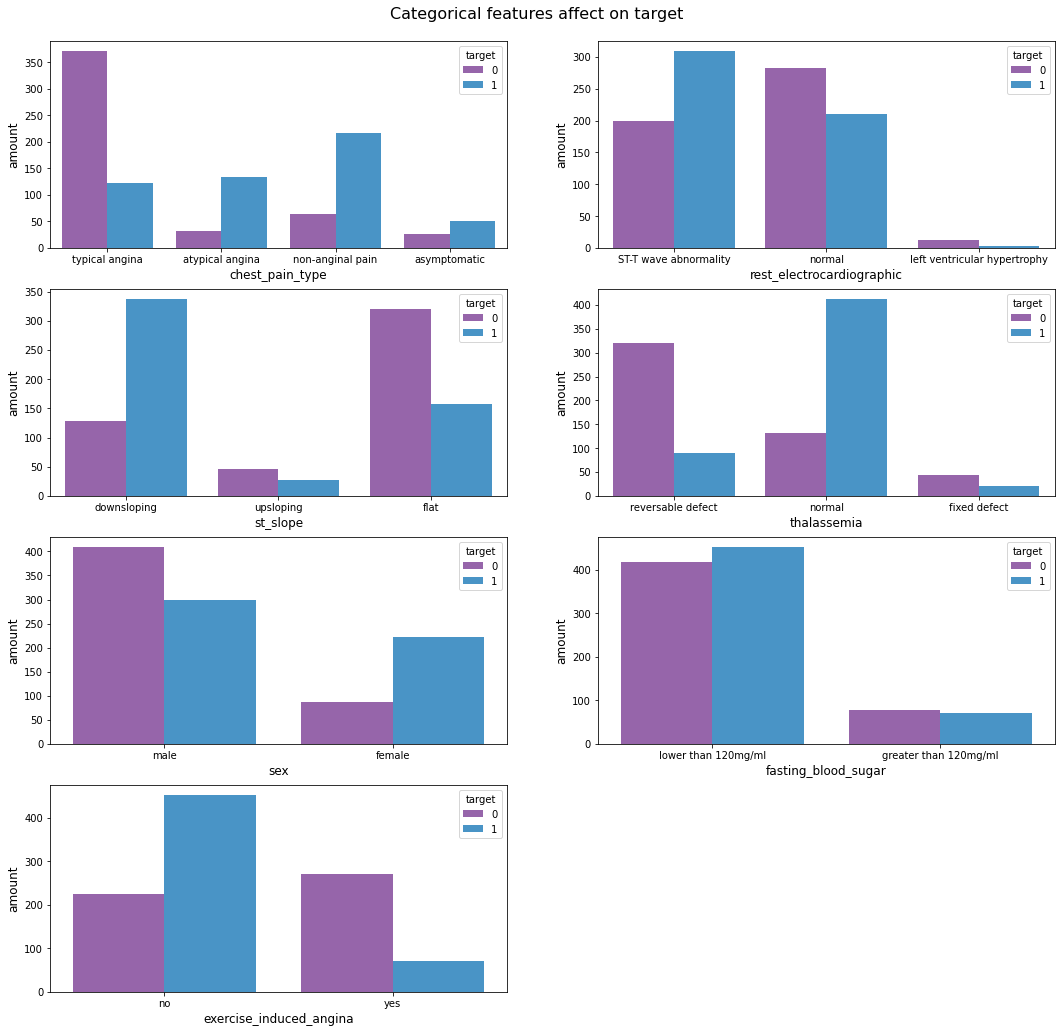

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(18, 16))    
fig.subplots_adjust(top=0.95)
ax.flat[7].set_visible(False)
for idx, feature in enumerate(categorical_features):
    plt.subplot(4, 2, idx + 1)
    ax = sns.countplot(data=df, x=feature, hue="target", palette=colors) 
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("amount", fontsize=12)
plt.suptitle('Categorical features affect on target' ,fontsize = 16)


### Correlations
A correlation heatmap is a heatmap that shows a 2D correlation matrix between two discrete dimensions, it is a useful tool to visually represent how features interact with each other. <br/>
Depending upon the data types of the features, we need to use the appropriate correlation methods such as: <br/>
1. Pearson's correlation coefficient - The Pearson's correlation is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1.<br/>
2. Spearman correlation - The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). <br/>
3. Cramers'V correlation - The Cramers'V correlation is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946.

Text(0.5, 1.05, "Pearson's Correlation")

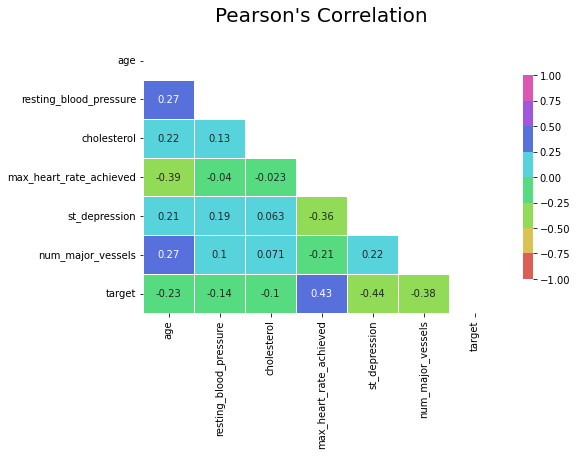

In [13]:
# pearson correlation
palet = sns.color_palette("hls", 8)
corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(palet)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Pearson's Correlation", fontsize=20, y= 1.05)

Text(0.5, 1.05, "Spearman's Correlation")

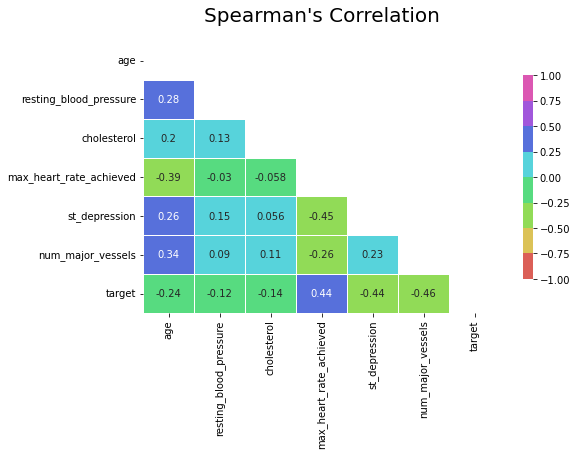

In [14]:
# spearman correlation
palet = sns.color_palette("hls", 8)
corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(palet)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Spearman's Correlation", fontsize=20, y= 1.05)

Text(0.5, 1.05, "Cramer's V correlation")

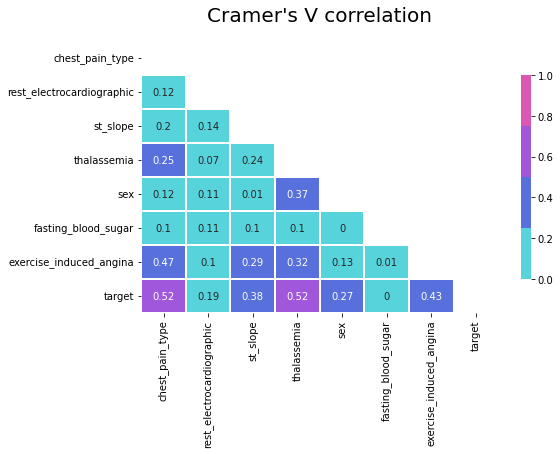

In [15]:
def cramers_v_correlation(x: pd.array, y: pd.array) -> float: 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = np.sum(np.sum(confusion_matrix))
    r, k = confusion_matrix.shape
    phi2corr = max(0, (chi2 / n) - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    cramers_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return cramers_v

# calculate the correlation coefficients using the above function
categorical_data = df[categorical_features]
rows= []
for r in categorical_data:
    col = []
    for c in categorical_data:
        x = categorical_data[r]
        y = categorical_data[c]
        cramers_v = cramers_v_correlation(x, y) 
        col.append(round(cramers_v, 2))
    rows.append(col)
    
cramers_results = np.array(rows)
results = pd.DataFrame(cramers_results, columns = categorical_data.columns, index = categorical_data.columns)

# plot the heat map
palet = sns.color_palette("hls", 8)
mask = np.triu(np.ones_like(results, dtype=bool))
corr = results.mask(mask)
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(palet)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Cramer's V correlation", fontsize=20, y= 1.05)

## 3. Machine learning

### 
Machine learning is a set of computer algorithms that can improve through experience and by the use of data.
Machine learning algorithms build a model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. 
Machine learning algorithms are used in a wide variety of applications, such as in medicine, email filtering, speech recognition, and computer vision, where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks.
In this section we will explore the use of some machine algorithms and try to understand:
1. which features do ML algorithms put most emphasise on?
2. Do machine learning models learn the underlying correlations between the parameters?
3. How well do these ML algorithms predict heart disease on the data? <br/>

Machine learning models used:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Naive Bayes
- Neural Network

In [16]:
# encode categorical labels to numerical labels and split the data into train and test
label_encoder = LabelEncoder()
data = df.copy()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(df[col])

features = data.columns[:-1]
x = data[features]
y = data['target']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=seed)

In [17]:
classifiers = [
    LogisticRegression(penalty='l2', C=0.28, solver="liblinear", random_state=seed),
    DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=seed),
    RandomForestClassifier(n_estimators=50, max_depth=3, random_state=seed),
    XGBClassifier(n_estimators=20, max_depth=3, objective='binary:logistic', random_state=seed),
    GaussianNB(),
    MLPClassifier(learning_rate='adaptive', random_state=seed)
]
clfs_id = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Naive Bayes', 'MLP neural network']

In [18]:
# train and test all the classifiers
header = ["Classifier", "Accuracy", "Precision", "Recall", "F1 score", "AUC-ROC"]
metric = pd.DataFrame(columns=header)
for idx, clf in enumerate(classifiers):        
    clf.fit(x_train, y_train)
    pred = clf.predict(x_val)
    probabilities = clf.predict_proba(x_val)[:, 1]
    accuracy = accuracy_score(y_val, pred)
    fpr, tpr, _ = roc_curve(y_val, probabilities)        
    cm = confusion_matrix(y_val, pred) 
    precision = cm[1,1]/(cm[1,1] +cm[0,1])
    recall = cm[1,1]/(cm[1,1] +cm[1,0])
    f1 = 2*recall*precision/(recall + precision)
    auc_roc = auc(fpr, tpr)
    df = pd.DataFrame([[clfs_id[idx], accuracy*100, precision, recall, f1, auc_roc]], columns=header)
    metric = metric.append(df)     

In [19]:
# show results
metric.reset_index()

,index,Classifier,Accuracy,Precision,Recall,F1 score,AUC-ROC
0,0,Logistic Regression,88.72549,0.884956,0.909091,0.896861,0.947389
1,0,Decision Tree,84.803922,0.855856,0.863636,0.859729,0.914652
2,0,Random Forest,90.196078,0.875,0.954545,0.913043,0.961605
3,0,XGBoost,96.568627,0.972477,0.963636,0.968037,0.995164
4,0,Naive Bayes,86.27451,0.841667,0.918182,0.878261,0.930077
5,0,MLP neural network,84.803922,0.816,0.927273,0.868085,0.94352


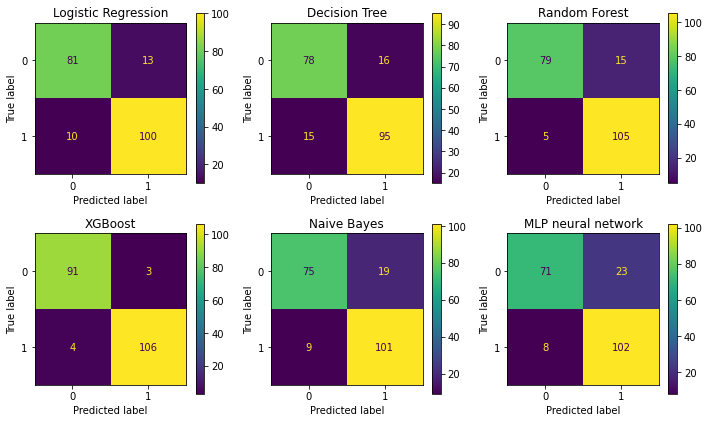

In [20]:
# plot confusion matrix
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.ravel()
for idx, clf in enumerate(classifiers):
    plot_confusion_matrix(clf, x_val, y_val, ax=axs[idx])
    axs[idx].title.set_text(clfs_id[idx])   
    
plt.tight_layout() 
plt.show()

### Explainablity
Model explainability refers to the concept of being able to understand the machine learning model. <br/>
Explainability is based on the concept that a machine learning model and its output can be explained in a way that “makes sense” to a human being at an acceptable level.
**Why is Model Explainability required?**
- Being able to interpret a model increases trust in a machine learning model. 
- Once we understand a model, we can detect if there is any bias present in the model. 

In our case, we can use model explainability to check whether the models learnt the underlying correlations of the data or whether the algorithms were biased by some other feature. <br/>
To do so, we will use three different approches:
1. SHAP - shows the impact of each feature by interpreting the impact of a certain value compared to a average of all the predictions.
2. LIME - provides a local interpretation by modifying feature values of a single data sample and observing its impact on the output.
3. Permutation Importance - eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available.

In [21]:
# fitting an XGBClassifier in order to explain it
xgb = XGBClassifier(n_estimators=20, max_depth=3, objective='binary:logistic', random_state=seed) 
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

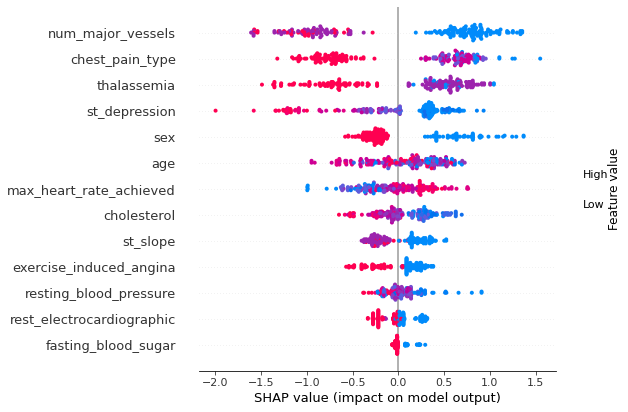

In [22]:
# SHAP
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_val)
shap.summary_plot(shap_values, x_val, feature_names=features, plot_type="dot")

In [23]:
# LIME 
explainer = lime_tabular.LimeTabularExplainer(x_train.values, mode="classification", feature_names=features)
idx = random.randint(1, len(x_train))
inst = x_train.iloc[idx]
prob = xgb.predict_proba
explanation = explainer.explain_instance(inst, prob)
explanation.show_in_notebook()

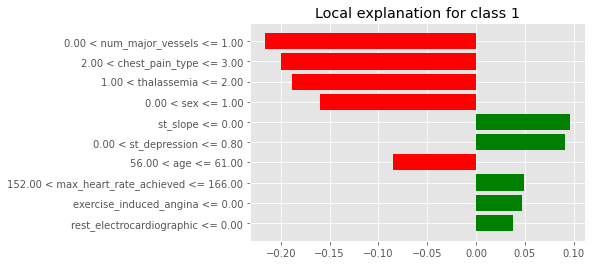

In [24]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

In [26]:
importance = eli5.sklearn.PermutationImportance(xgb, random_state=seed).fit(x_train, y_train)
eli5.show_weights(importance, feature_names = x_val.columns.tolist())

Weight,Feature
0.0990 ± 0.0114,num_major_vessels
0.0813 ± 0.0150,chest_pain_type
0.0639 ± 0.0062,thalassemia
0.0506 ± 0.0120,age
0.0477 ± 0.0122,st_depression
0.0342 ± 0.0068,sex
0.0332 ± 0.0041,max_heart_rate_achieved
0.0216 ± 0.0095,cholesterol
0.0157 ± 0.0063,resting_blood_pressure
0.0128 ± 0.0089,exercise_induced_angina
